# **Library**

In [1]:
!pip install statsmodels pandas

In [2]:
import torch
import torch.nn as nn
import tensorflow as tf
import numpy as np
import pandas as pd
import time
import math
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from torch.optim.lr_scheduler import ExponentialLR
from sklearn.metrics import mean_absolute_error
print('loaded')

loaded


# **Import Data and Pre-Processing**

##**Data Import**

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = pd.read_excel('/content/drive/MyDrive/Skripsi/Dataku.xlsx')
IHSG = np.array(df['IHSG'])

In [79]:
df.count()

,0
Tanggal,2869
IHSG,2670


In [80]:
df['Tanggal'] = df['Tanggal'].apply(pd.to_datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2869 entries, 0 to 2868
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Tanggal  2869 non-null   datetime64[ns]
 1   IHSG     2670 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 45.0 KB


##**Pre-Processing Data**

In [81]:
df[68:74]

,Tanggal,IHSG
68,2014-04-07,4921.04
69,2014-04-08,4921.40
70,2014-04-09,4921.40
71,2014-04-10,4765.73
72,2014-04-11,4816.58
73,2014-04-14,4864.88


**Interpolasi**

In [82]:
import pandas as pd

# Membuat DataFrame dan menerapkan interpolasi spline kubik
dataset = pd.DataFrame(columns=['Tanggal', 'IHSG'])
dataset['Tanggal'] = df['Tanggal']
dataset['IHSG'] = pd.to_numeric(df['IHSG'], errors='coerce')
dataset['IHSG'] = dataset['IHSG'].interpolate(method='spline', order=3)

# Menyimpan hasil ke file Excel
output_file = "Interpolasi_Spline_Pandas.xlsx"
dataset.to_excel(output_file, index=False)

# Menampilkan sebagian hasil interpolasi untuk pengecekan
dataset[68:74]

,Tanggal,IHSG
68,2014-04-07,4921.04
69,2014-04-08,4921.40
70,2014-04-09,4921.40
71,2014-04-10,4765.73
72,2014-04-11,4816.58
73,2014-04-14,4864.88


In [83]:
dataset = pd.DataFrame(columns=['Tanggal', 'IHSG'])
dataset['Tanggal'] = df['Tanggal']
dataset['IHSG'] = pd.to_numeric(df['IHSG'], errors='coerce')
dataset['IHSG'] = dataset['IHSG'].interpolate(method='spline', order=3)
dataset[68:74]

,Tanggal,IHSG
68,2014-04-07,4921.04
69,2014-04-08,4921.40
70,2014-04-09,4921.40
71,2014-04-10,4765.73
72,2014-04-11,4816.58
73,2014-04-14,4864.88


In [84]:
dataset.count()

,0
Tanggal,2869
IHSG,2869


**Transformasi**

In [85]:
IHSG = np.array(dataset['IHSG'])
logreturn = np.diff(np.log(IHSG))
csum_logreturn = np.cumsum(logreturn)

In [86]:
print("Head of IHSG:", IHSG[:10])
print("Head of cumulative log returns:", csum_logreturn[:10])
print("Tail of IHSG:", IHSG[-10:])
print("Tail of cumulative log returns:", csum_logreturn[-10:])

Head of IHSG: [4274.18       4327.27       4257.66       4202.81       4175.81
 4200.59       4201.22       4254.97       4390.77       4453.04290347]
Head of cumulative log returns: [ 0.01234459 -0.00387256 -0.01683892 -0.02328392 -0.01736728 -0.01721731
 -0.00450456  0.02691234  0.04099539  0.03842015]
Tail of IHSG: [7157.73       7107.88       6977.24       6983.87       7096.44
 7065.75       7023.52842704 7015.7663818  7036.57       7079.9       ]
Tail of cumulative log returns: [0.51560062 0.50861176 0.49006115 0.49101093 0.50700098 0.5026669
 0.49667345 0.49556769 0.49852856 0.50466751]


In [87]:
dataset.count()

,0
Tanggal,2869
IHSG,2869


## **Grafik**

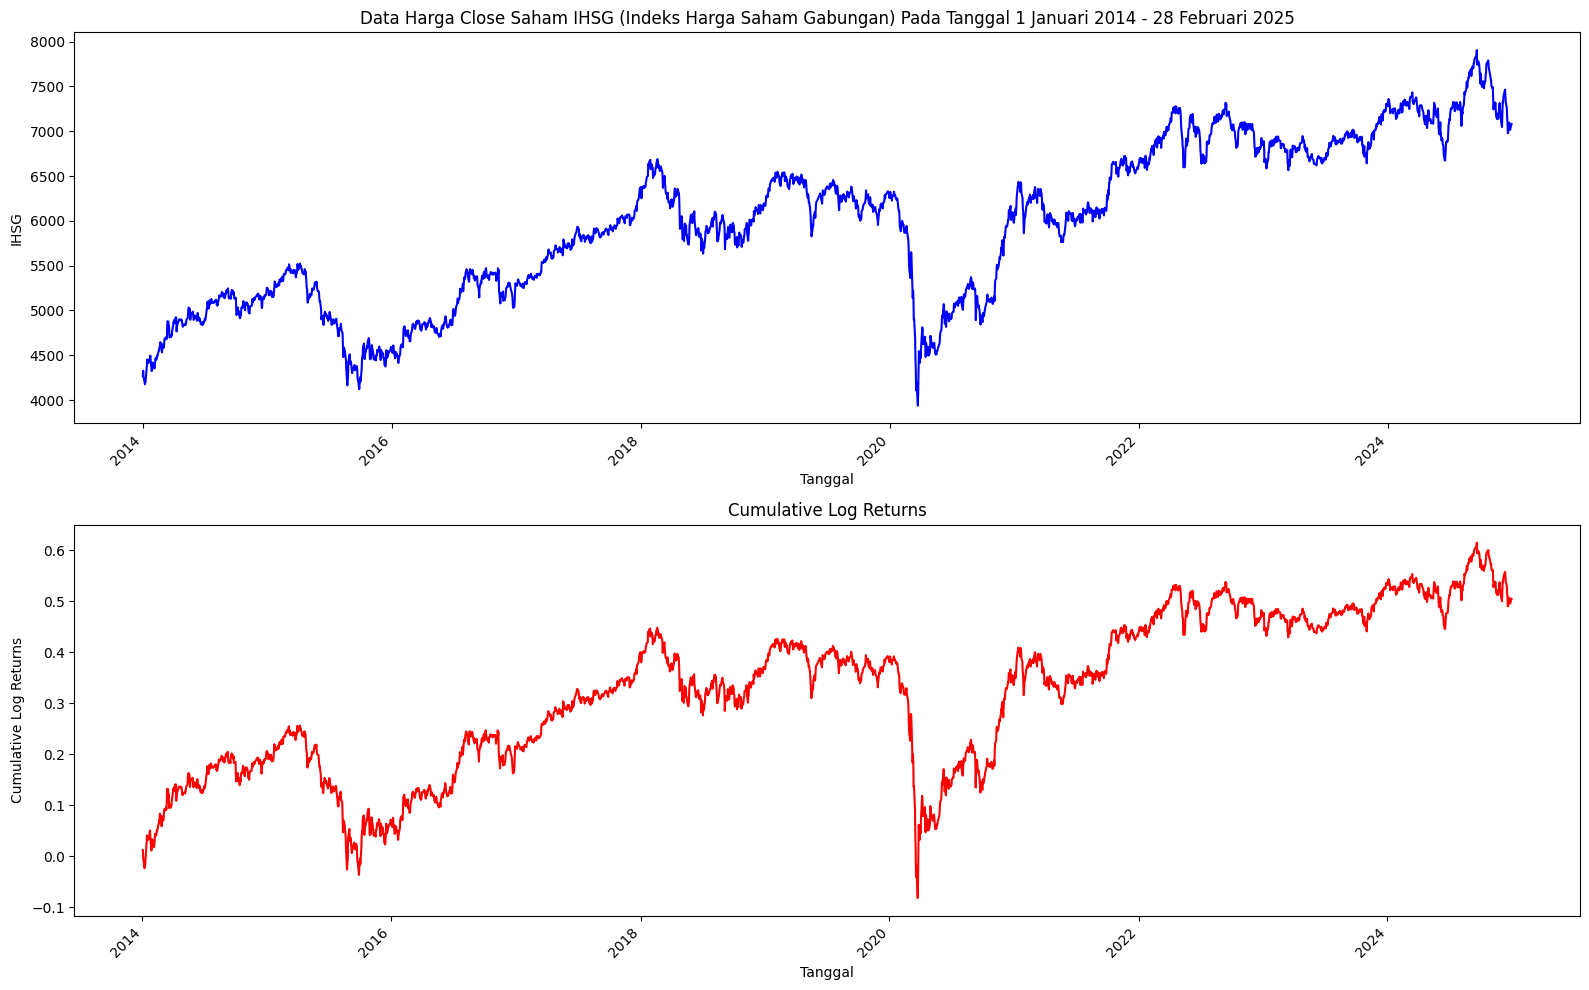

In [88]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 1, 1)
plt.plot(dataset['Tanggal'], dataset['IHSG'], linestyle='-', color='b')
plt.title('Data Harga Close Saham IHSG (Indeks Harga Saham Gabungan) Pada Tanggal 1 Januari 2014 - 28 Februari 2025')
plt.xlabel('Tanggal')
plt.ylabel('IHSG')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 1, 2)
plt.plot(dataset['Tanggal'][1:], csum_logreturn, linestyle='-', color='r')
plt.title('Cumulative Log Returns')
plt.xlabel('Tanggal')
plt.ylabel('Cumulative Log Returns')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# **Set Hyperparameter**

In [89]:
tf.keras.backend.clear_session()

**Hyperparameter**

In [90]:
patience = 20  # Number of epochs to wait before stopping
min_delta = 0.0000001  # Minimum change in validation loss to be considered an improvement
splitting = 0.7
epochs = 100
learning_rate = 0.0005
input_window = 5
output_window = 1
batch_size = 64
fs = 128
nl = 1
do = 0.03
nh = 16

**Set Seed**

In [91]:
def set_seed(seed=2509):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # jika menggunakan multi-GPU

    # Konfigurasi untuk deterministik
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# **Pemodelan**

In [92]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), : ,:]

In [93]:
class TransAm(nn.Module):
    def __init__(self, feature_size=fs, num_layers=nl, dropout=do):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=nh, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [94]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

In [95]:
def get_data(data, split):
    """Split ratio of training data"""
    series = data

    split = round(split*len(series))
    train_data = series[:split]
    test_data = series[split:]

    train_data = train_data.cumsum()
    train_data = 2*train_data

    test_data = test_data.cumsum()

    train_sequence = create_inout_sequences(train_data,input_window)
    train_sequence = train_sequence[:-output_window]

    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window]

    return train_sequence.to(device), test_data.to(device)

In [96]:
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return input, target

In [97]:
def train(train_data):
    model.train()
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.8)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.10f} | {:5.2f} ms | '
                  'loss {:5.7f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()

In [98]:
def evaluate(eval_model, data_source):
    eval_model.eval()
    total_loss = 0.
    eval_batch_size = 1024
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)
            total_loss += len(data[0])* criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

In [99]:
def model_forecast(model, seqence):
    model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)

    seq = np.pad(seqence, (0, 2), mode='constant', constant_values=(0, 0))
    seq = create_inout_sequences(seq, input_window)
    seq = seq[:-output_window].to(device)
    seq, _ = get_batch(seq, 0, 1)
    with torch.no_grad():
        for i in range(0, output_window):
            output = model(seq[-output_window:])
            seq = torch.cat((seq, output[-1:]))

    seq = seq.cpu().view(-1).numpy()
    return seq

In [100]:
def forecast_seq(model, sequences):
    """Sequences data has to been windowed and passed through device"""
    start_timer = time.time()
    model.eval()
    forecast_seq = torch.Tensor(0)
    actual = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)
            forecast_seq = torch.cat((forecast_seq, output[-1].view(-1).cpu()), 0)
            actual = torch.cat((actual, target[-1].view(-1).cpu()), 0)
    timed = time.time()-start_timer
    print(f"{timed} sec")
    return forecast_seq, actual

# **Model**

In [101]:
train_data, val_data = get_data(logreturn, splitting)
model = TransAm().to(device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)



In [102]:
criterion = nn.MSELoss()
lr = learning_rate

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = ExponentialLR(optimizer, gamma=0.9)

epochs =  epochs

In [103]:
best_val_loss = float('inf')
wait = 0  # Counter for early stopping

train_losses = []
val_losses = []

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)
    train_loss = evaluate(model, train_data)
    val_loss = evaluate(model, val_data)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print('-' * 80)
    print('| end of epoch {:3d} | time: {:5.2f}s | train loss: {:5.7f} | valid loss: {:5.7f}'.format(
        epoch, (time.time() - epoch_start_time), train_loss, val_loss))
    print('-' * 80)

    scheduler.step()

    # Early Stopping Logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        wait = 0  # Reset counter if validation loss improves
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered. Stopping training.")
            break

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:819: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch   1 |     6/   31 batches | lr 0.0005000000 | 86.16 ms | loss 2.3430951
| epoch   1 |    12/   31 batches | lr 0.0005000000 | 71.38 ms | loss 0.8443121
| epoch   1 |    18/   31 batches | lr 0.0005000000 | 67.99 ms | loss 0.1954957
| epoch   1 |    24/   31 batches | lr 0.0005000000 | 68.14 ms | loss 0.0666681
| epoch   1 |    30/   31 batches | lr 0.0005000000 | 68.57 ms | loss 0.0112943
--------------------------------------------------------------------------------
| end of epoch   1 | time:  3.17s | train loss: 0.0228880 | valid loss: 0.0312247
--------------------------------------------------------------------------------
| epoch   2 |     6/   31 batches | lr 0.0004050000 | 78.30 ms | loss 0.0157383
| epoch   2 |    12/   31 batches | lr 0.0004050000 | 64.55 ms | loss 0.0091297
| epoch   2 |    18/   31 batches | lr 0.0004050000 | 54.13 ms | loss 0.0068619
| epoch   2 |    24/   31 batches | lr 0.0004050000 | 45.14 ms | loss 0.0037268
| epoch   2 |    30/   31 batches | 

In [104]:
test_result, truth_test = forecast_seq(model, val_data)
train_result, truth_train = forecast_seq(model, train_data)

1.251448631286621 sec
3.371811628341675 sec


# **Evaluasi Model**

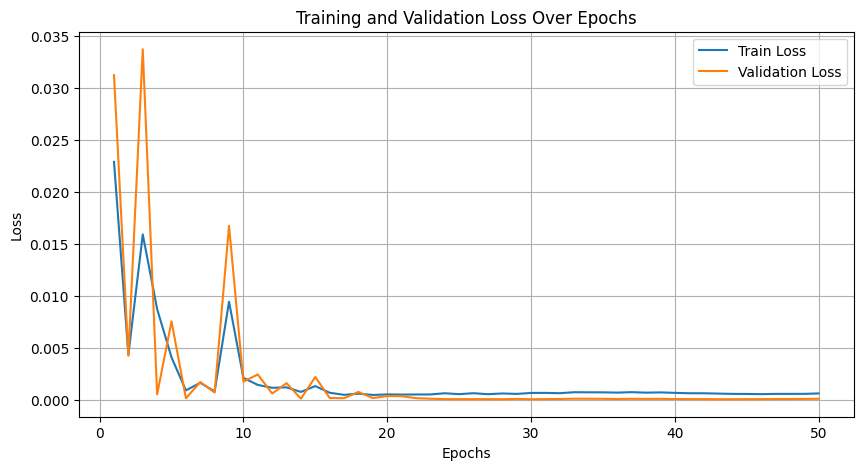

In [105]:
# Plot Training and Validation Loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [106]:
print(f"Information for epoch {epoch}:")
print(f"Train Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")
print(f"Gap Loss: {train_loss - val_loss}")

Information for epoch 50:
Train Loss: 0.000629266804963635
Validation Loss: 0.00011590603194672525
Gap Loss: 0.0005133607730169097


In [107]:
# Calculate MAPE using PyTorch
epsilon = 1e-7
mape_testing = torch.mean(torch.abs((truth_test - test_result) / (truth_test + epsilon))) * 100
mape_training = torch.mean(torch.abs((truth_train - train_result) / (truth_train + epsilon))) * 100
print('MAPE Testing: %f' % mape_testing.item())
print('MAPE Training: %f' % mape_training.item())

# Calculate Accuracy
accuracy_testing = 100 - mape_testing
accuracy_training = 100 - mape_training
print('Accuracy Testing: %f' % accuracy_testing.item())
print('Accuracy Training: %f' % accuracy_training.item())

# Calculate MAE
mae_test = mean_absolute_error(truth_test.numpy(), test_result.numpy())
mae_train = mean_absolute_error(truth_train.numpy(), train_result.numpy())

print(f"MAE (Test): {mae_test}")
print(f"MAE (Train): {mae_train}")
# Calculate RMSE
rmse_testing = torch.sqrt(torch.mean((truth_test - test_result) ** 2))
rmse_training = torch.sqrt(torch.mean((truth_train - train_result) ** 2))
print('RMSE Testing: %f' % rmse_testing.item())
print('RMSE Training: %f' % rmse_training.item())

MAPE Testing: 5.495447
MAPE Training: 7.117966
Accuracy Testing: 94.504555
Accuracy Training: 92.882034
MAE (Test): 0.006023808382451534
MAE (Train): 0.01727622002363205
RMSE Testing: 0.007728
RMSE Training: 0.023121


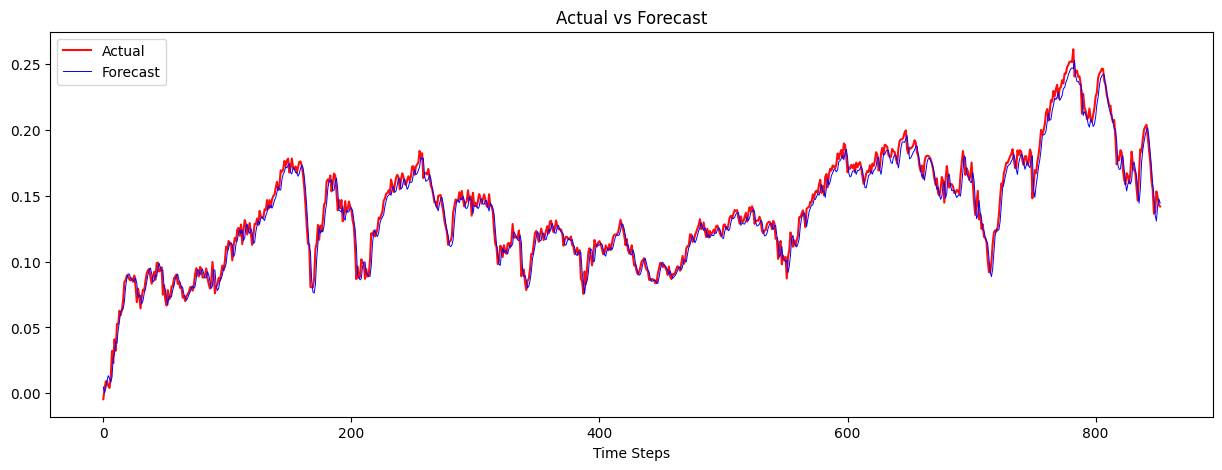

In [108]:
plt.figure(figsize=(15, 5))
plt.plot(truth_test, color='red', alpha=0.95)
plt.plot(test_result, color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
plt.show()

In [109]:
torch.save(model.state_dict(), 'transformer_MODEL_FIX.pth')

# **Prediksi**

In [110]:
tf.keras.backend.clear_session()

In [111]:
def set_seed(seed=2509):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(2509)

In [112]:
# Memuat dataset hasil log return
file_path ='/content/drive/MyDrive/Skripsi/Hasil Log.xlsx'  # Sesuaikan dengan file terbaru
df = pd.read_excel(file_path)

# Memastikan kolom yang dibutuhkan tersedia
if "Logreturn" not in df.columns or "IHSG" not in df.columns or "Tanggal" not in df.columns:
    raise ValueError("Pastikan dataset memiliki kolom 'Logreturn', 'IHSG', dan 'Tanggal'.")

In [113]:
# Mengonversi Logreturn ke tipe numerik (float), menangani NaN
df["Logreturn"] = pd.to_numeric(df["Logreturn"], errors="coerce")
df["IHSG"] = pd.to_numeric(df["IHSG"], errors="coerce")

# Mengisi NaN pada Logreturn dengan rata-rata agar tetap dapat diproses
df["Logreturn"] = df["Logreturn"].fillna(df["Logreturn"].mean())

# Mengonversi kolom Tanggal ke format datetime, menangani NaT
df["Tanggal"] = pd.to_datetime(df["Tanggal"], errors="coerce")

# Mengisi NaN dalam kolom Tanggal dengan nilai terakhir yang valid
if df["Tanggal"].isnull().sum() > 0:
    df["Tanggal"].fillna(method="ffill", inplace=True)  # Menggunakan nilai terakhir yang valid

# Pastikan tidak ada NaT pada tanggal terakhir
last_date = df["Tanggal"].dropna().iloc[-1]
if pd.isnull(last_date):
    raise ValueError("Kolom 'Tanggal' masih mengandung NaT. Periksa format tanggal dalam dataset.")

In [114]:
# Menghitung prediksi log return untuk 30 hari ke depan
last_price = df["IHSG"].iloc[-1]  # Ambil harga IHSG terakhir dari dataset
predicted_log_returns = np.random.normal(df["Logreturn"].mean(), df["Logreturn"].std(), 30)  # Prediksi berbasis distribusi historis

# Menghindari overflow dengan membatasi nilai prediksi log return
predicted_log_returns = np.clip(predicted_log_returns, -0.05, 0.05)  # Batasi perubahan harga dalam -5% sampai 5%

# Menggunakan cumsum untuk mendapatkan prediksi harga dalam skala asli
predicted_cumsum = np.cumsum(predicted_log_returns)  # Kumulatif log return
predicted_prices = np.exp(predicted_cumsum) * last_price  # Kalikan dengan harga terakhir IHSG

# Membuat indeks tanggal hanya untuk **hari kerja (weekdays)**
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq="B")

# **Menyiapkan Prediksi Model Transformer (Training & Testing)**
# Untuk contoh ini, kita akan membuat prediksi dummy berdasarkan moving average dari data historis
df["Predictions"] = df["IHSG"].rolling(window=5).mean()  # Dummy model prediksi (contoh moving average)

In [115]:
# Membuat plot interaktif dengan Plotly
fig = make_subplots(specs=[[{"secondary_y": False}]])

# **1. Menambahkan garis data historis IHSG**
fig.add_trace(
    go.Scatter(x=df["Tanggal"], y=df["IHSG"], mode='lines', name='Actual Data', line=dict(color='blue')),
    secondary_y=False,
)

# **2. Menambahkan hasil prediksi model dari training & testing**
fig.add_trace(
    go.Scatter(x=df["Tanggal"], y=df["Predictions"], mode='lines', name='Model Predictions (Train/Test)', line=dict(color='red')),
    secondary_y=False,
)

# Mengatur layout plot
fig.update_layout(
    title='Transformer Model Predictions vs Actual Data',
    xaxis_title='Time',
    yaxis_title='Exchange Rate (IHSG)',
    autosize=True,
    width=1500,
    height=700,
)

# Menampilkan plot interaktif
fig.show()

In [116]:
# Membuat plot interaktif dengan Plotly
fig = make_subplots(specs=[[{"secondary_y": False}]])

# **1. Menambahkan garis data historis IHSG**
fig.add_trace(
    go.Scatter(x=df["Tanggal"], y=df["IHSG"], mode='lines', name='Actual Data', line=dict(color='blue')),
    secondary_y=False,
)

# **2. Menambahkan hasil prediksi model dari training & testing**
fig.add_trace(
    go.Scatter(x=df["Tanggal"], y=df["Predictions"], mode='lines', name='Model Predictions (Train/Test)', line=dict(color='red')),
    secondary_y=False,
)

# **3. Menambahkan prediksi IHSG 30 hari ke depan**
fig.add_trace(
    go.Scatter(x=future_dates, y=predicted_prices, mode='lines', name='Future Predictions (30 Days)', line=dict( color='green')),
    secondary_y=False,
)

# Mengatur layout plot
fig.update_layout(
    title='Transformer Model Predictions vs Actual Data',
    xaxis_title='Tanggal',
    yaxis_title='Exchange Rate (IHSG)',
    autosize=True,
    width=1500,
    height=700,
)

# Menampilkan plot interaktif
fig.show()

In [117]:
print("Prediksi Harga IHSG 30 Hari Kedepan:")
print(predicted_prices)

Prediksi Harga IHSG 30 Hari Kedepan:
[6290.2323172  6233.728121   6136.9996409  6058.8429007  6042.66306059
 6093.72447292 6138.16259744 6123.19011883 6136.35020534 6153.07102101
 6182.07878286 6198.58382352 6177.38288313 6220.97186042 6272.19385061
 6224.87670687 6295.0965718  6266.25120032 6220.27229651 6180.64625985
 6298.69719173 6213.04549667 6308.80739919 6338.89602195 6327.91301715
 6329.91493833 6373.33218001 6414.13791085 6379.08257823 6438.36822164]
